### Training of modified U-Net for Optic Disc on RIM-ONE v3 database, 256 px images (cross-validation fold #0).

You can either train your model or upload a pre-trained one from:
*../models_weights/03.03,14:19,U-Net light, on RIM-ONE v3 256 px fold 0, SGD, high augm, CLAHE, log_dice loss/last_checkpoint.hdf5*.

In [2]:
__versio

NameError: name '__versio' is not defined

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import tensorflow as tf
import skimage
import skimage.exposure
#import mahotas as mh
from sklearn.model_selection import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
#from tqdm import tqdm_notebook
from IPython.display import display
from dual_IDG import DualImageDataGenerator

Using TensorFlow backend.


In [4]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Conv2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, \
    Lambda, UpSampling2D, Cropping2D, Concatenate
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [5]:
print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.3.1
TensorFlow version: 2.0.0


In [6]:
K.set_image_data_format('channels_first')

In [7]:
def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    #X_fl = K.clip(K.batch_flatten(X), K.epsilon(), 1.)
    #Y_fl = K.clip(K.batch_flatten(Y), K.epsilon(), 1.)
    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.cast(K.greater(X_fl, 0.5), 'float32')
    Y_fl = K.cast(K.greater(Y_fl, 0.5), 'float32')

    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), K.ones_like(union), union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

In [8]:
def dice(y_true, y_pred):
    # Workaround for shape bug. For some reason y_true shape was not being set correctly
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    #y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    #y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    #y_pred_f = K.greater(y_pred_f, 0.5)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)


def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)


def log_dice_loss(y_true, y_pred):
    return -K.log(dice(y_true, y_pred))


def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
    y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
    return dice(y_true_f, y_pred_f)

In [9]:
def tf_to_th_encoding(X):
    return np.rollaxis(X, 3, 1)


def th_to_tf_encoding(X):
    return np.rollaxis(X, 1, 4)

In [10]:
#h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'all_data.hdf5'), 'r')
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'RIM_ONE_v3.hdf5'), 'r')

### U-Net architecture

<img src="../pics/u_net_arch.png" width=80%>

In [11]:
def get_unet_light(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv5)

    up6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv6)

    up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv7)

    up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv8)

    up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(input=inputs, output=conv10)

    return model

In [12]:
model = get_unet_light(img_rows=256, img_cols=256)
model.compile(optimizer=SGD(lr=1e-3, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

model.summary()

2024-04-09 19:21:19.337239: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-04-09 19:21:19.421952: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa053527a50 executing computations on platform Host. Devices:
2024-04-09 19:21:19.421989: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 256, 256)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 256, 256) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 256, 256) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 256, 256) 9248        dropout_1[0][0]                  
____________________________________________________________________________________________

/Users/tomasknapcok/DocumentsLocal/STUFEI/optic-nerve-cnn/venv/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


#### RIM-ONE v3

Accessing data, preparing train/validation sets division:

In [13]:
X = h5f['RIM-ONE v3/256 px/images']
Y = h5f['RIM-ONE v3/256 px/disc']

In [14]:
X, Y

(<HDF5 dataset "images": shape (159, 256, 256, 3), type "|u1">,
 <HDF5 dataset "disc": shape (159, 256, 256, 1), type "|u1">)

In [16]:
train_idx_cv, test_idx_cv = [], []

for _train_idx, _test_idx in KFold(n_splits=5, shuffle=True, random_state=1).split(X):
    print(_train_idx, _test_idx)
    train_idx_cv.append(_train_idx)
    test_idx_cv.append(_test_idx)

[  0   1   2   3   4   6   7   8   9  10  12  13  15  17  18  20  21  22
  23  24  25  26  27  28  30  32  33  34  36  37  38  39  41  43  45  46
  47  48  49  50  52  53  55  56  57  58  60  61  62  63  64  65  67  68
  69  70  71  72  74  75  76  77  78  79  80  82  83  85  86  87  88  92
  95  96  98  99 101 102 104 106 107 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 144 146 147 148 149 150 151 152 154 155 156 157
 158] [  5  11  14  16  19  29  31  35  40  42  44  51  54  59  66  73  81  84
  89  90  91  93  94  97 100 103 105 108 127 143 145 153]
[  0   1   2   3   5   6   7   8   9  10  11  14  15  16  19  20  21  22
  23  24  25  26  27  29  30  31  32  34  35  37  38  40  41  42  43  44
  46  49  50  51  52  54  55  57  59  60  61  62  63  64  65  66  67  68
  70  71  72  73  74  76  79  80  81  82  83  84  85  86  87  88  89  90
  91  93  94  95  96  97  98  99 100 101 103 104 105 107 108

In [17]:
#train_idx = h5f['RIM-ONE v3/train_idx_driu']
#test_idx = h5f['RIM-ONE v3/test_idx_driu']

train_idx = train_idx_cv[0]
test_idx = test_idx_cv[0]

In [18]:
len(X), len(train_idx), len(test_idx)

(159, 127, 32)

#### Generator of augmented data:

In [19]:
train_idg = DualImageDataGenerator(#rescale=1/255.0,
                                   #samplewise_center=True, samplewise_std_normalization=True,
                                   horizontal_flip=True, vertical_flip=True,
                                   rotation_range=50, width_shift_range=0.15, height_shift_range=0.15,
                                   zoom_range=(0.7, 1.3),
                                   fill_mode='constant', cval=0.0)
test_idg = DualImageDataGenerator()

#### Preprocessing function and data generator:

In [20]:
def preprocess(batch_X, batch_y, train_or_test='train'):
    batch_X = batch_X / 255.0
    batch_y = batch_y / 255.0
    if train_or_test == 'train':
        batch_X, batch_y = next(train_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False))
    elif train_or_test == 'test':
        batch_X, batch_y = next(test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False))
    batch_X = th_to_tf_encoding(batch_X)
    batch_X = [skimage.exposure.equalize_adapthist(batch_X[i]) 
               for i in range(len(batch_X))]
    batch_X = np.array(batch_X)
    batch_X = tf_to_th_encoding(batch_X)
    return batch_X, batch_y


def data_generator(X, y, train_or_test='train', batch_size=3, return_orig=False, stationary=False):    
    while True:
        if train_or_test == 'train':
            idx = np.random.choice(train_idx, size=batch_size)
        elif train_or_test == 'test':
            if stationary:
                idx = test_idx[:batch_size]
            else:
                idx = np.random.choice(test_idx, size=batch_size)
        batch_X = [X[i] for i in idx]
        batch_X = np.array(batch_X).copy()
        batch_y = [y[i] for i in idx]
        batch_y = np.array(batch_y).copy()
        batch_X = tf_to_th_encoding(batch_X)
        batch_y = tf_to_th_encoding(batch_y)
        if return_orig:
            batch_X_orig, batch_Y_orig = batch_X.copy(), batch_y.copy()
        
        batch_X, batch_y = preprocess(batch_X, batch_y, train_or_test)
        
        if not return_orig:
            yield batch_X, batch_y
        else:
            yield batch_X, batch_y, batch_X_orig, batch_Y_orig

Testing the data generator and generator for augmented data:

In [21]:
gen = data_generator(X, Y, 'train', batch_size=1)
batch = next(gen)
batch[0].shape

(1, 3, 256, 256)

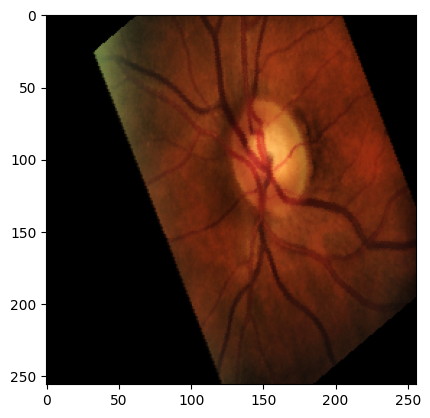

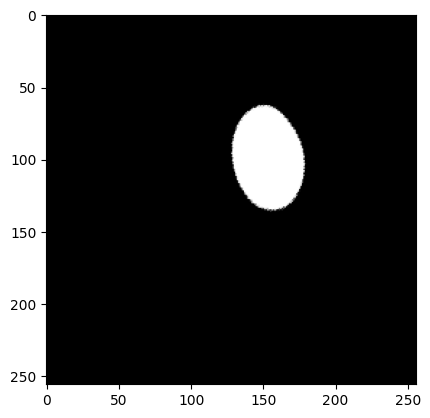

In [22]:
fig = plt.imshow(np.rollaxis(batch[0][0], 0, 3))
#plt.colorbar(mappable=fig)
plt.show()
plt.imshow(batch[1][0][0], cmap=plt.cm.Greys_r); plt.show()

In [23]:
arch_name = "U-Net light, on RIM-ONE v3 256 px fold 0, SGD, high augm, CLAHE, log_dice loss"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                 '{},{}/'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name))
print(weights_folder)

/Users/tomasknapcok/DocumentsLocal/STUFEI/optic-nerve-cnn/models_weights/09.04,19:24,U-Net light, on RIM-ONE v3 256 px fold 0, SGD, high augm, CLAHE, log_dice loss/


In [24]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

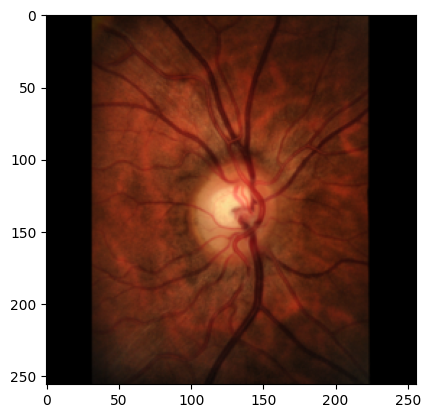

(32, 3, 256, 256) (32, 1, 256, 256)


In [25]:
X_valid, Y_valid = next(data_generator(X, Y, train_or_test='test', batch_size=100, stationary=True))
plt.imshow(np.rollaxis(X_valid[0], 0, 3)); plt.show()
print(X_valid.shape, Y_valid.shape)

### Training

If a pretrained model needs to be used, first run "Loading model" section below and then go the "Comprehensive visual check", skipping this section.

In [ ]:
history = model.fit_generator(data_generator(X, Y, train_or_test='train', batch_size=1), 
                              steps_per_epoch=99,
                              max_queue_size=1,
                              
                              validation_data=(X_valid, Y_valid),
                              #validation_data=data_generator(X, Y, train_or_test='test', batch_size=1),
                              #nb_val_samples=100,
                              
                              epochs=500, verbose=1,
                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log.csv')),
                                         #ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, verbose=1, patience=40),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               #'weights.ep-{epoch:02d}-val_mean_IOU-{val_mean_IOU_gpu:.2f}_val_loss_{val_loss:.2f}.hdf5',
                                               'last_checkpoint.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

### Comprehensive visual check

image #5


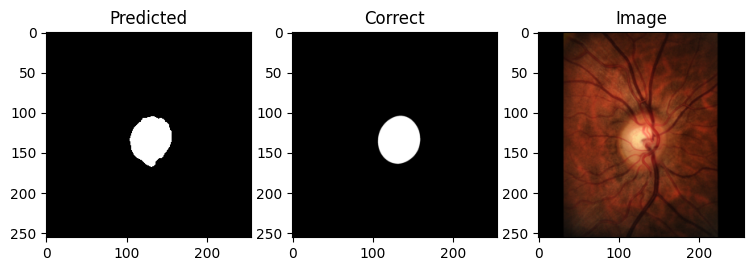

IOU: 0.8578143119812012
Dice: 0.9298919010346185
image #11


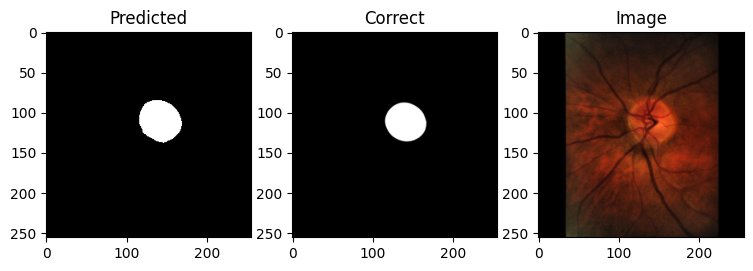

IOU: 0.8756404519081116
Dice: 0.9405799932788783
image #14


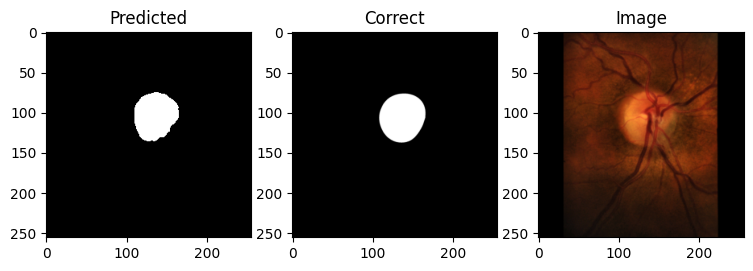

IOU: 0.8894058465957642
Dice: 0.9477895275961465
image #16


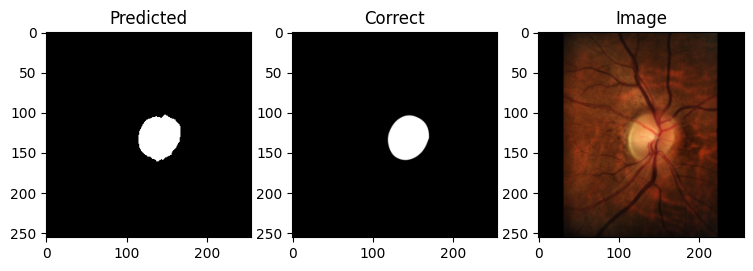

IOU: 0.8359081149101257
Dice: 0.9180478236485754
image #19


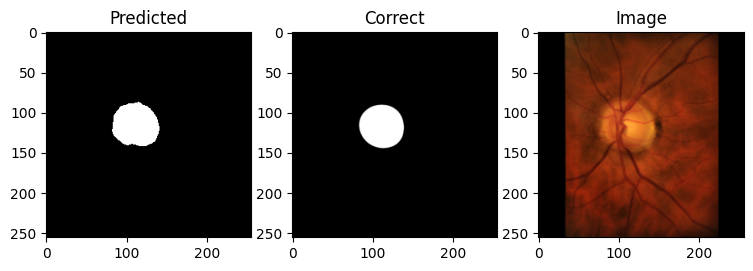

IOU: 0.8900970816612244
Dice: 0.9480220327861764
image #29


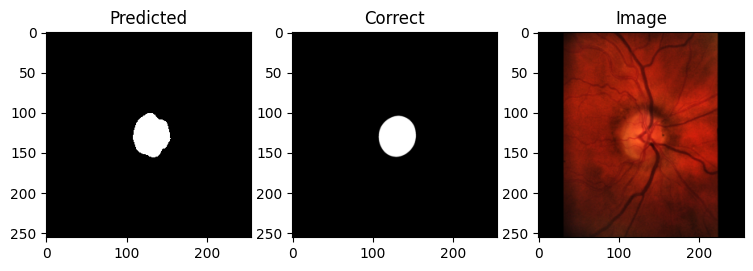

IOU: 0.9158003926277161
Dice: 0.9625049040473955
image #31


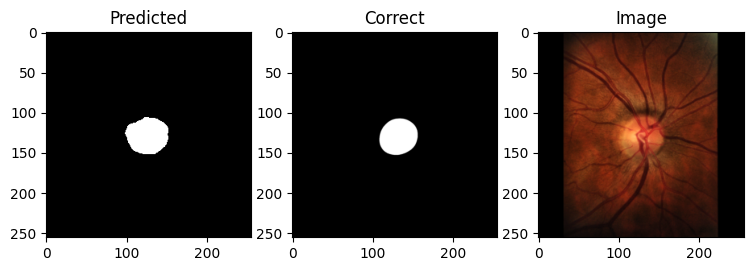

IOU: 0.7352941036224365
Dice: 0.8552486708050341
image #35


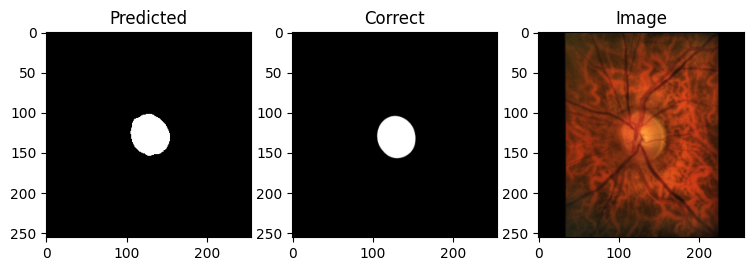

IOU: 0.8687258958816528
Dice: 0.938879627996825
image #40


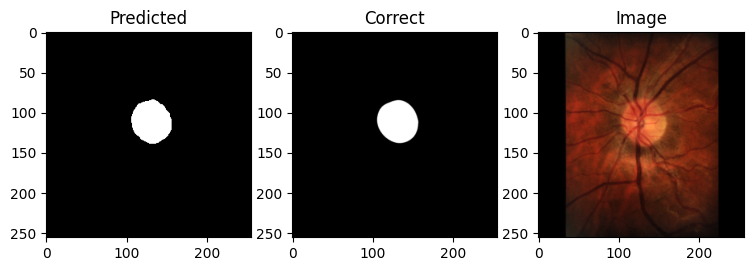

IOU: 0.9560336470603943
Dice: 0.9835834705129985
image #42


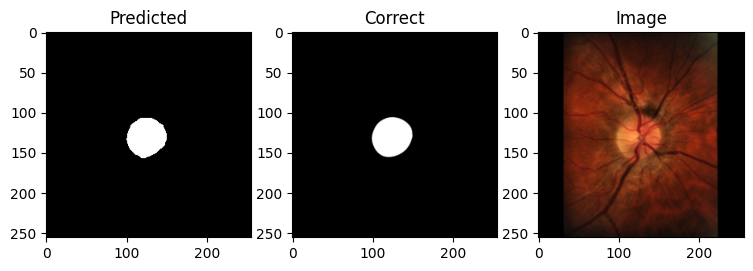

IOU: 0.9409651160240173
Dice: 0.9765371710721629
image #44


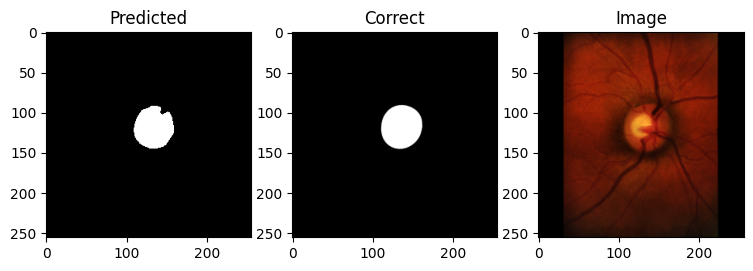

IOU: 0.8818263411521912
Dice: 0.9438314329305271
image #51


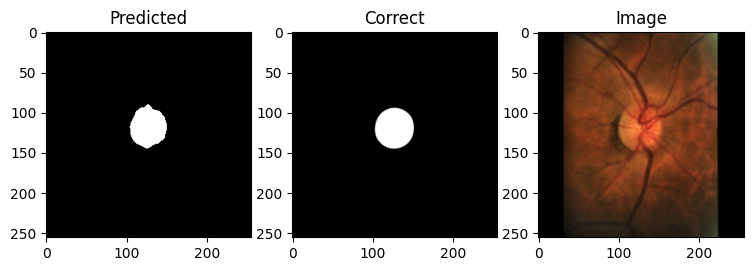

IOU: 0.8874809741973877
Dice: 0.9495885119607573
image #54


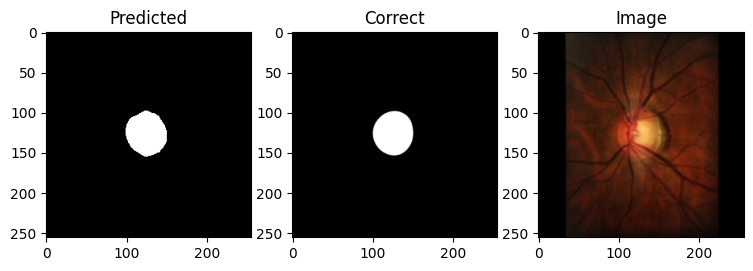

IOU: 0.9202834367752075
Dice: 0.9653352339820548
image #59


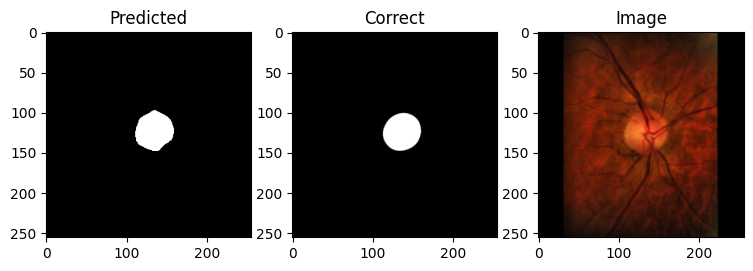

IOU: 0.865037202835083
Dice: 0.9344045906826262
image #66


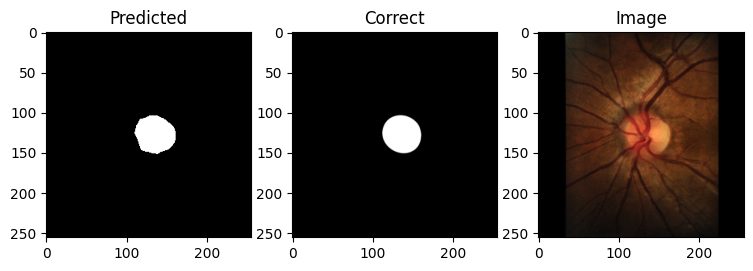

IOU: 0.9143310189247131
Dice: 0.9631661316877886
image #73


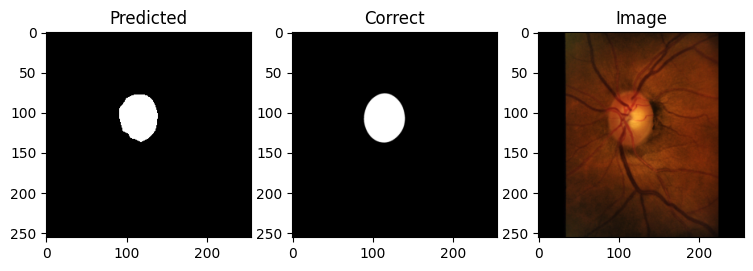

IOU: 0.903171956539154
Dice: 0.9557435989217385
image #81


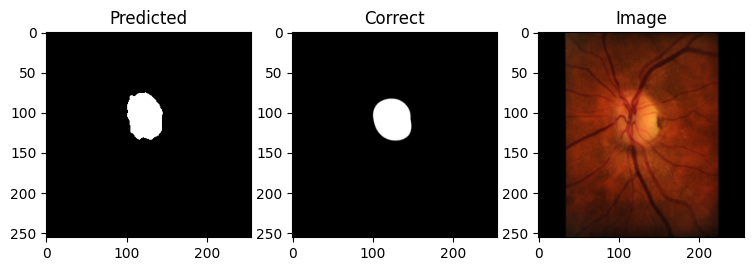

IOU: 0.7895204424858093
Dice: 0.8890257895739605
image #84


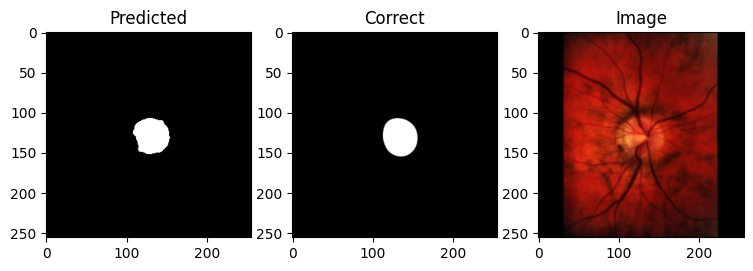

IOU: 0.824471116065979
Dice: 0.9121533210554044
image #89


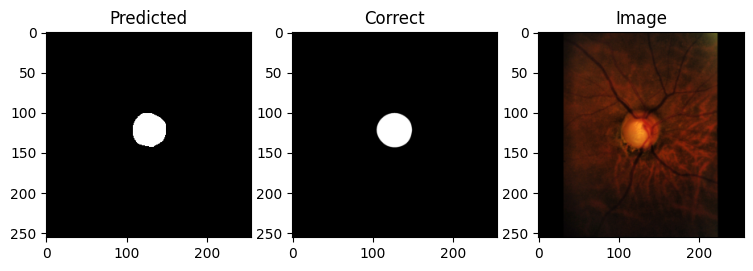

IOU: 0.9356604814529419
Dice: 0.9719523906246995
image #90


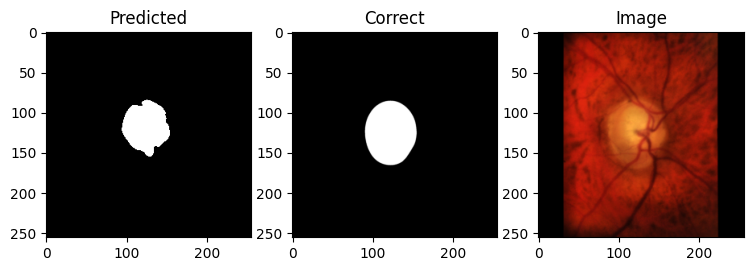

IOU: 0.7030978798866272
Dice: 0.83198641306483
image #91


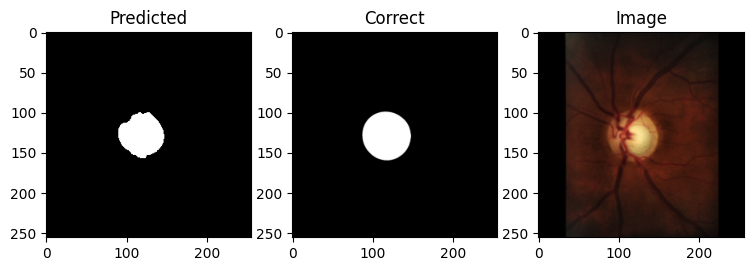

IOU: 0.8202247023582458
Dice: 0.9100051933742607
image #93


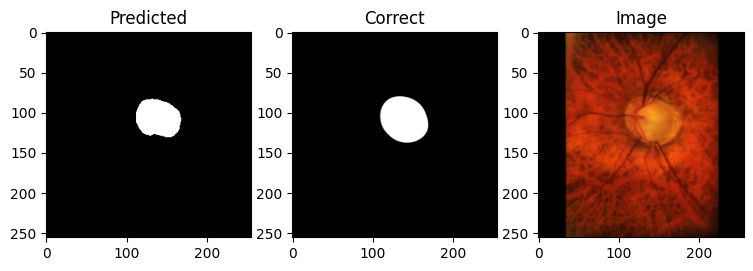

IOU: 0.7907150983810425
Dice: 0.890606234534628
image #94


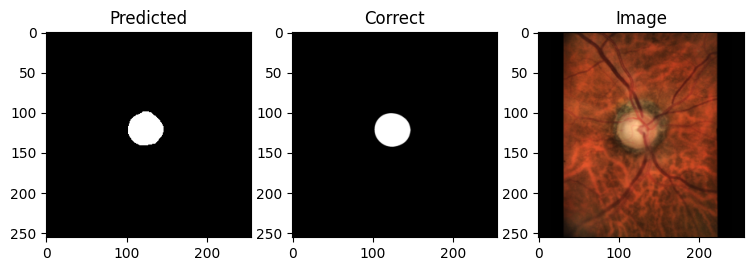

IOU: 0.9041916131973267
Dice: 0.9586915903258053
image #97


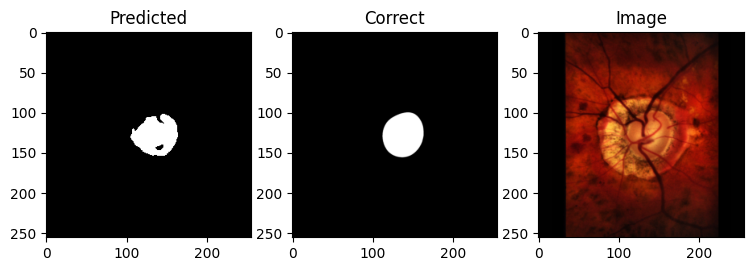

IOU: 0.841296911239624
Dice: 0.9197105210704034
image #100


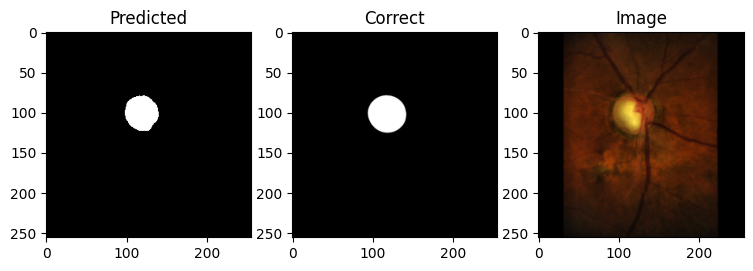

IOU: 0.8270238637924194
Dice: 0.914983831580586
image #103


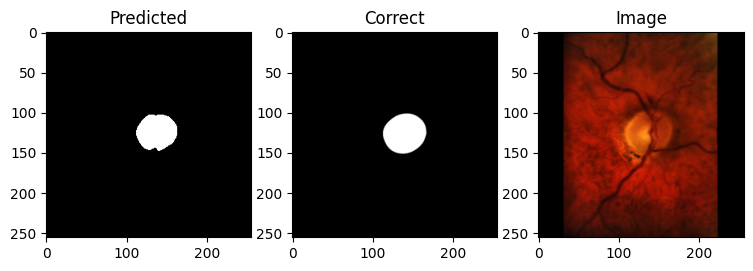

IOU: 0.8217164278030396
Dice: 0.9089861531999612
image #105


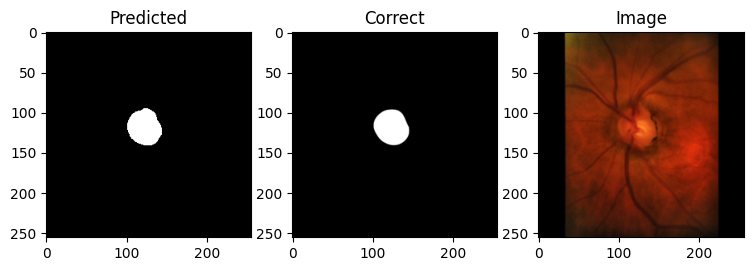

IOU: 0.9125401973724365
Dice: 0.9647024130623099
image #108


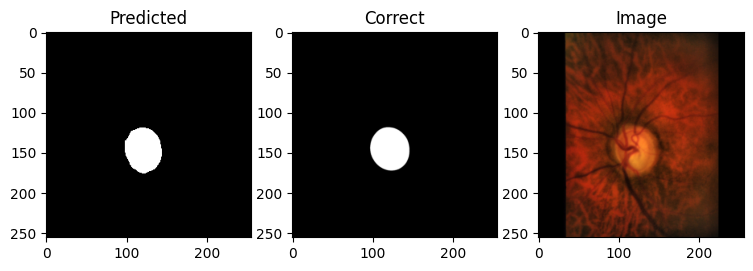

IOU: 0.907216489315033
Dice: 0.960473965938048
image #127


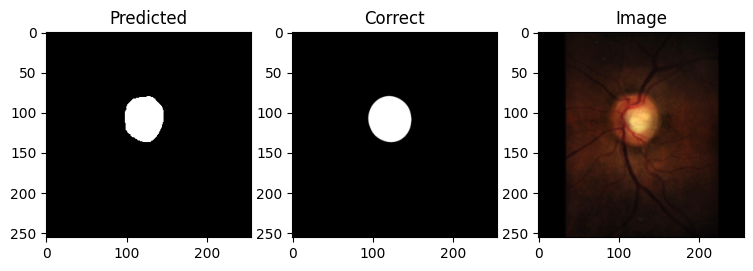

IOU: 0.9036144614219666
Dice: 0.9568710390681573
image #143


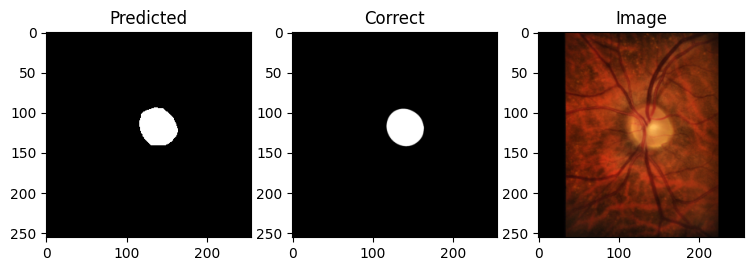

IOU: 0.9065473079681396
Dice: 0.9606367167352684
image #145


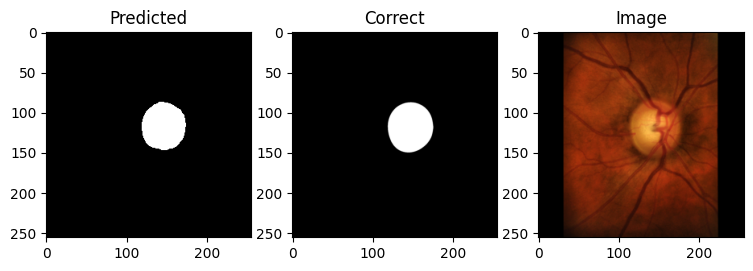

IOU: 0.9225783348083496
Dice: 0.9656915308751726
image #153


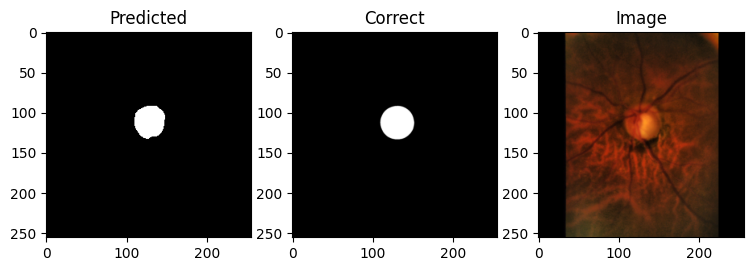

IOU: 0.863210916519165
Dice: 0.933969276206242


In [27]:
pred_iou, pred_dice = [], []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = X[img_no]
    batch_X = X_valid[i:i + 1]
    batch_y = Y_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    # mean filtering:
    #pred = mh.mean_filter(pred, Bc=mh.disk(10)) > 0.5
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    cur_iou = K.eval(mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]))
    cur_dice = K.eval(dice(pred[None, None, ...], corr[None, None, ...]))
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

Acquiring scores for the validation set:

In [28]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

0.86910754
0.9363625313510637


Showing the best and the worst cases:

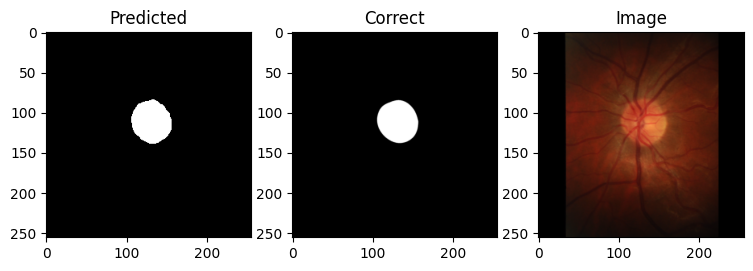

IOU: 0.9560336470603943, Dice: 0.9835834705129985 (best)


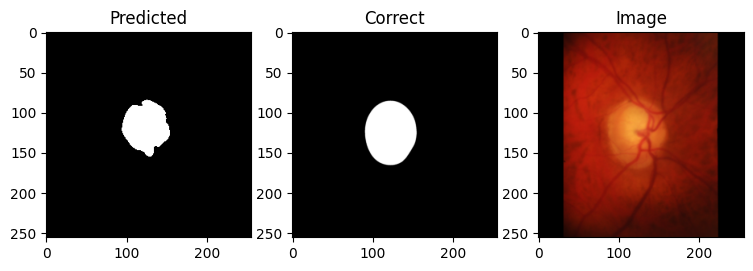

IOU: 0.7030978798866272, Dice: 0.83198641306483 (worst)


In [29]:
def show_img_pred_corr(i, file_suffix):    # i is index of image in test_idx
    img_no = test_idx[i]
    batch_X = X[img_no:img_no + 1]
    batch_X = tf_to_th_encoding(batch_X)
    batch_y = Y[img_no:img_no + 1]
    batch_y = tf_to_th_encoding(batch_y)
    batch_X, batch_y = preprocess(batch_X, batch_y, 'test')
    
    pred = model.predict(batch_X)[0, 0] > 0.5
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(X[img_no])
    ax.set_title('Image')
    plt.show()
    
    plt.imsave('od_rim_one_v3_fold_0_{}_case_image.png'.format(file_suffix), X[img_no])
    plt.imsave('od_rim_one_v3_fold_0_{}_case_pred.png'.format(file_suffix), pred, cmap=plt.cm.Greys_r)
    plt.imsave('od_rim_one_v3_fold_0_{}_case_corr.png'.format(file_suffix), corr, cmap=plt.cm.Greys_r)


best_idx = np.argmax(pred_iou)
worst_idx = np.argmin(pred_iou)
show_img_pred_corr(best_idx, 'best')
print('IOU: {}, Dice: {} (best)'.format(pred_iou[best_idx], pred_dice[best_idx]))
show_img_pred_corr(worst_idx, 'worst')
print('IOU: {}, Dice: {} (worst)'.format(pred_iou[worst_idx], pred_dice[worst_idx]))

### Loading model

In [26]:
load_model = True   # lock
if not load_model:
    print('load_model == False')
else:
    # UNCOMMENT APPROPRIATE LINE(S) BELOW:
    # specify file:
    #model_path = '../models_weights/01.11,22:38,U-Net on DRIONS-DB 256 px, Adam, augm, log_dice loss/' \
    #    'weights.ep-20-val_mean_IOU-0.81_val_loss_0.08.hdf5'
    # or get the most recently altered file in a folder:
    model_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights', '03.03,14_19,U-Net light, on RIM-ONE v3 256 px fold 0, SGD, high augm, CLAHE, log_dice loss')
    
    model_path = max(glob.glob(os.path.join(model_folder, '*.hdf5')), key=os.path.getctime)
    if load_model and not os.path.exists(model_path):
        raise Exception('`model_path` does not exist')
    print('Loading weights from', model_path)

    if load_model:
        #with open(model_path + ' arch.json') as arch_file:
        #    json_string = arch_file.read()
        #new_model = model_from_json(json_string)
        model.load_weights(model_path)
    
    # Reading log statistics
    import pandas as pd
    
    log_path = os.path.join(model_folder, 'training_log.csv')
    if os.path.exists(log_path):
        log = pd.read_csv(log_path)
        if log['epoch'].dtype != 'int64':
            log = log.loc[log.epoch != 'epoch']
        print('\nmax val mean IOU: {}, at row:'.format(log['val_mean_IOU_gpu'].max()))
        print(log.loc[log['val_mean_IOU_gpu'].idxmax()])
        if 'val_dice_metric' in log.columns:
            print('\n' + 'max val dice_metric: {}, at row:'.format(log['val_dice_metric'].max()))
            print(log.loc[log['val_dice_metric'].idxmax()])
        if 'val_dice' in log.columns:
            print('\n' + 'max val dice: {}, at row:'.format(log['val_dice'].max()))
            print(log.loc[log['val_dice'].idxmax()])

Loading weights from /Users/tomasknapcok/DocumentsLocal/STUFEI/optic-nerve-cnn/models_weights/03.03,14_19,U-Net light, on RIM-ONE v3 256 px fold 0, SGD, high augm, CLAHE, log_dice loss/last_checkpoint.hdf5

max val mean IOU: 0.8809200096879999, at row:
epoch               196.000000
dice_metric           0.902209
loss                  0.071331
mean_IOU_gpu          0.826438
val_dice_metric       0.936309
val_loss              0.042184
val_mean_IOU_gpu      0.880920
Name: 196, dtype: float64

max val dice_metric: 0.936309117824, at row:
epoch               196.000000
dice_metric           0.902209
loss                  0.071331
mean_IOU_gpu          0.826438
val_dice_metric       0.936309
val_loss              0.042184
val_mean_IOU_gpu      0.880920
Name: 196, dtype: float64
